#Creating a shallow neural network - MLP (Multi-Layer Perceptron)

In [2]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.2 MB/s eta 0:00:00


In [3]:
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils import class_weight
import math
from sklearn.utils.class_weight import compute_class_weight
from keras import regularizers
from imblearn.over_sampling import SMOTE
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import keras_tuner as kt
import random

In [4]:
# Load data into pandas dataframe
data = pd.read_csv('/content/drive/MyDrive/final year/btc_tx_anomaly_detection/data/cleaned_undersampled_data.csv', index_col=False)
y = data['is_fraud']
X = data.drop('is_fraud', axis=1)

# Split the data into training, validation and test sets

In [5]:
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

# Split into training, validation and test data
# Stratify to get even distribution of classes in the training and test data
# This is useful because we have an uneven class proprtion (far fewer fraudulent transactions)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=42, stratify=y)

# Create validation set as 15% of orginal dataset (not 10% of X_train which would be 10% of 80%)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), stratify=y_test)

In [6]:
# check fraudulent transactions are distribited in the same
print(y_train.value_counts()[1] / y.value_counts()[1])
print(y_test.value_counts()[1]/ y.value_counts()[1])
print(y_val.value_counts()[1]/ y.value_counts()[1])

0.7962962962962963
0.10185185185185185
0.10185185185185185


In [7]:
y_test.value_counts()

0.0    1122
1.0      11
Name: is_fraud, dtype: int64

In [8]:
def show_hist():
  vis_data = pd.DataFrame(history.history)
  vis_data.plot()

In [9]:
def make_prediction(model):
  return model.predict(X_test)

# ROC and AUC
To see how well our model is performing, the ROC and AUC metrics are good.

ROC will tell us the tradeoff between how many fraudulent transactions are correctly identified (true positive rate) and how many legitimate transactions are identified incorrectly as fruadulent (false positive rate), at varying thresholds.




In [10]:
# Plot ROC curve
def plot_roc(y_pred, fpr, tpr):

  roc_auc = auc(fpr, tpr)

  plt.figure(figsize=(4, 4))
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')


  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend(loc='lower right')
  plt.show()

## Confusion Matrix

In [11]:
def display_cm(y_pred, thresholds):

  best_tpr_index = np.argmax(tpr- fpr)
  best_threshold = thresholds[best_tpr_index]
  predictions = (y_pred > best_threshold).astype(int)
  y_true = y_test
  cm = confusion_matrix(y_true, predictions)

  # Plot the confusion matrix as a heatmap
  plt.figure(figsize=(8, 6))

  group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
  group_percentages = ['{:.2%}'.format(value) for value in (cm / cm.sum(axis=1)[:, np.newaxis]).flatten()]
  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts,group_percentages)]

  labels = np.asarray(labels).reshape(2,2)
  tick_labels = ['Non-Fraud', 'Fraud']
  sns.heatmap(cm, annot=labels, fmt='s', xticklabels=tick_labels, yticklabels=tick_labels)

  plt.title('Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

  # Print classification report for additional metrics
  print("Classification Report:")
  print(classification_report(y_true, predictions))


## MLP

tunable-hyperparameters:
* Number of hidden layers
* Number of Neurons in each layer
* weight regularization (l1, l2 - weigth decay)
* class_weights
* drop out layers
* optimisers
* optimiser learning rate

# Experimental results


Baseline MLP structure:

Input layer:
- The number of neurons is pretty arbitary, we'll go for 32 for the input layer
- Doesn't need an activation function because it's just taking in the data

Output Layer
- Output layer needs have a single neuron because this is a binary classification task
- Therefore we'll need to use sigmoid to give us a prediction probability between 0-1

Hidden layer:
- The data is not particularly linear therefore it will require at least 1 hidden layer
- The number of neurons should be between the number of neurons in the input and output layers, we'll start off with 16

Other Hyperparameters:
* Loss: Binary cross entropty
* Optimiser: SGD/Adam
* Learning Rate: default
* Class weights: default
* Kernal normalisation: None
* Batch normalisation: None
* Dropouts: None
* Epochs: 60



Epoch 1/60
284/284 [==============================] - 3s 7ms/step - loss: 0.1873 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - f1_score: 0.0188 - val_loss: 0.0562 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.0192
Epoch 2/60
284/284 [==============================] - 1s 4ms/step - loss: 0.0533 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - f1_score: 0.0188 - val_loss: 0.0529 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.0192
Epoch 3/60
284/284 [==============================] - 1s 4ms/step - loss: 0.0516 - precision_1: 0.3333 - recall_1: 0.0116 - f1_score: 0.0188 - val_loss: 0.0506 - val_precision_1: 1.0000 - val_recall_1: 0.0909 - val_f1_score: 0.0192
Epoch 4/60
284/284 [==============================] - 1s 3ms/step - loss: 0.0506 - precision_1: 0.5000 - recall_1: 0.0349 - f1_score: 0.0188 - val_loss: 0.0500 - val_precision_1: 1.0000 - val_recall_1: 0.0909 - val_f1_score: 0.0192
Epoch 5/60
284/284 [====================

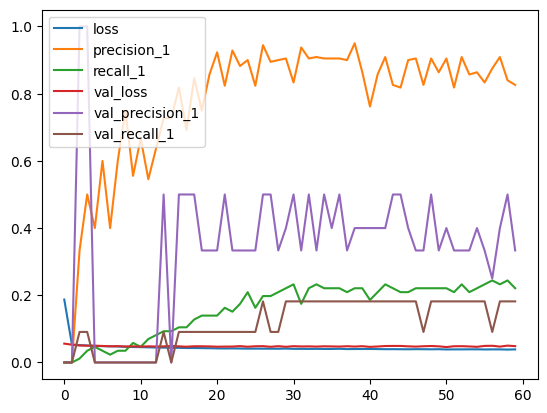

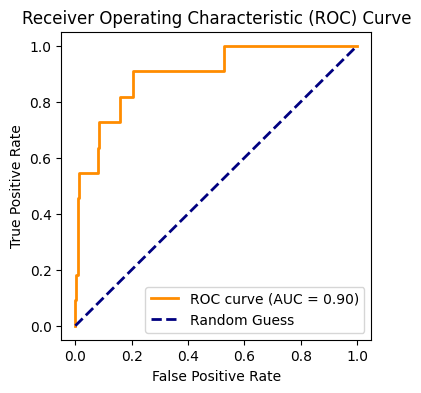

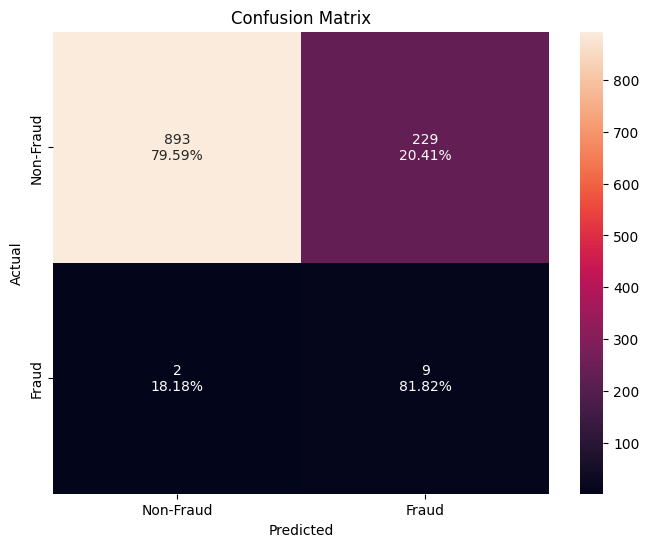

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.80      0.89      1122
         1.0       0.04      0.82      0.07        11

    accuracy                           0.80      1133
   macro avg       0.52      0.81      0.48      1133
weighted avg       0.99      0.80      0.88      1133



In [13]:
# Experiment 1 - Baseline
model = keras.models.Sequential()
model.add(keras.layers.Dense(32, input_shape=(11, )))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()])


checkpoint_filepath = '/content/drive/MyDrive/final year/btc_tx_anomaly_detection/models/mlp/checkpoint_1'

#early_stopping = EarlyStopping(monitor='val_f1_score', mode='max', patience=8)

checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                             monitor='val_f1_score', mode='max', save_best_only=True)

history = model.fit(X_train, y_train, epochs=60, validation_data=[X_val, y_val], callbacks=[checkpoint])

model = keras.models.load_model(checkpoint_filepath)

# show the training performance histogram
show_hist()
# make predictions on test data
predictions = make_prediction(model)
# plot the roc curve
fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=1)
plot_roc(predictions, fpr, tpr)
# take a deeper look and see how the model predicted the samples
display_cm(predictions, thresholds)

With such an imbalanced dataset, the model actually didn't perform too badly on the test set. It was able to identify 9/11 fraudulent transactions. However, the problem this model has is that it also made a lot of false negative predictions, meaning it mislabelled a lot of legitimate transactions as fraudulent.

Now, in a fraud detection model, the cost of mislabelling a legitimate transaction is lower when compared to the cost of mislabelling a fraudulent transaction. In a real life setting, it may be acceptable to allow for some legit transactions to be classed as fraudulent, if it means that the model is able to get almost all if not all of the fraudulent transactions.

We could try modify out MLP to try and improve both the precision and the recall

1. Adding class weight
2. Oversampling the minority (fraud) class to try and balance out the data

# Adding class weights
This will introduce a higher penalty for mislabelling a positive (fraud) sample more, and therefore the model will pay more attention to minimising this and hopefully give us better results

The typical way to assign class weights is to assign them inversley proportially to their ratio. So for example, in this dataset, we have roughly 100x more negative samples than positive samples, so we can assign the class 1 (positive) sample to be 100x more.

## Weighted MLP

Epoch 1/60
284/284 [==============================] - 5s 10ms/step - loss: 1.3440 - precision_3: 0.0197 - recall_3: 0.0698 - f1_score: 0.0188 - val_loss: 0.6433 - val_precision_3: 0.0331 - val_recall_3: 0.3636 - val_f1_score: 0.0192
Epoch 2/60
284/284 [==============================] - 1s 4ms/step - loss: 1.2943 - precision_3: 0.0246 - recall_3: 0.2907 - f1_score: 0.0188 - val_loss: 0.6753 - val_precision_3: 0.0175 - val_recall_3: 0.4545 - val_f1_score: 0.0192
Epoch 3/60
284/284 [==============================] - 1s 4ms/step - loss: 1.2605 - precision_3: 0.0220 - recall_3: 0.4767 - f1_score: 0.0188 - val_loss: 0.5644 - val_precision_3: 0.0465 - val_recall_3: 0.3636 - val_f1_score: 0.0192
Epoch 4/60
284/284 [==============================] - 1s 4ms/step - loss: 1.2038 - precision_3: 0.0438 - recall_3: 0.3953 - f1_score: 0.0188 - val_loss: 0.5629 - val_precision_3: 0.0367 - val_recall_3: 0.3636 - val_f1_score: 0.0192
Epoch 5/60
284/284 [==============================] - 1s 4ms/step - los

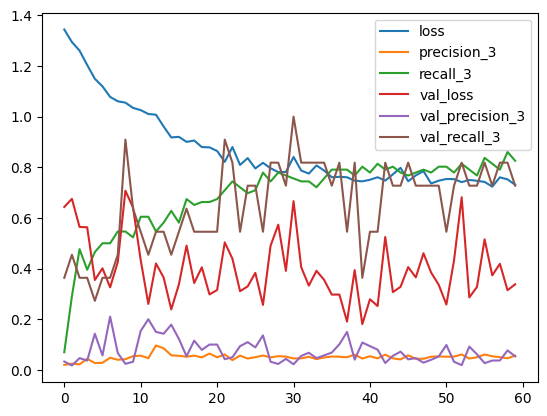

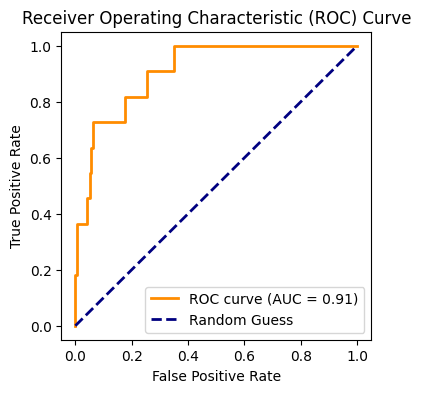

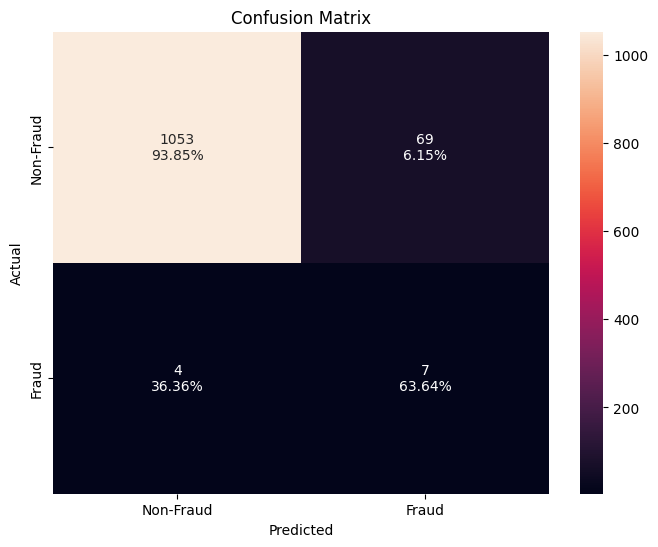

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97      1122
         1.0       0.09      0.64      0.16        11

    accuracy                           0.94      1133
   macro avg       0.54      0.79      0.56      1133
weighted avg       0.99      0.94      0.96      1133



In [15]:
# Experiment 2 - Introduce class weights
mlp_weighted = keras.models.Sequential()
mlp_weighted.add(keras.layers.Dense(32, input_shape=(11, )))
mlp_weighted.add(keras.layers.Dense(16, activation='relu'))
mlp_weighted.add(keras.layers.Dense(8, activation='relu'))
mlp_weighted.add(keras.layers.Dense(1, activation='sigmoid'))
mlp_weighted.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()])

checkpoint_filepath = '/content/drive/MyDrive/final year/btc_tx_anomaly_detection/models/mlp/checkpoint_2'

#early_stopping = EarlyStopping(monitor='val_f1_score', mode='max', patience=8)

checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                             monitor='val_f1_score', mode='max', save_best_only=True)

history = mlp_weighted.fit(X_train, y_train, epochs=60, class_weight={0:1., 1:100.}, validation_data=[X_val, y_val], callbacks=[checkpoint])

mlp_weighted = keras.models.load_model(checkpoint_filepath)

# show the training performance histogram
show_hist()
# make predictions on test data
predictions = make_prediction(mlp_weighted)
# plot the roc curve
fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=1)
plot_roc(predictions, fpr, tpr)
# take a deeper look and see how the model predicted the samples
display_cm(predictions, thresholds)

From this experiment we can see that by adjusting the weight, it actually reduced the recall slightly, so more fraudulent transactions were missed. Howevever the false negatives has drasrically reduced.

Instead of modifying the class weights to 1:100 ratio, we can use the sklearn compute_class_weights to estimate what weights to use.

In [17]:
weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)
class_weights = {0: weights[0], 1: weights[1]}
class_weights

{0: 0.504791620236238, 1: 52.674418604651166}

Epoch 1/60
284/284 [==============================] - 6s 13ms/step - loss: 0.6921 - precision_6: 0.0144 - recall_6: 0.2558 - f1_score: 0.0188 - val_loss: 0.6561 - val_precision_6: 0.2500 - val_recall_6: 0.2727 - val_f1_score: 0.0192
Epoch 2/60
284/284 [==============================] - 2s 8ms/step - loss: 0.6770 - precision_6: 0.0206 - recall_6: 0.3721 - f1_score: 0.0188 - val_loss: 0.5227 - val_precision_6: 0.3333 - val_recall_6: 0.1818 - val_f1_score: 0.0192
Epoch 3/60
284/284 [==============================] - 1s 5ms/step - loss: 0.6549 - precision_6: 0.0604 - recall_6: 0.3372 - f1_score: 0.0188 - val_loss: 0.4593 - val_precision_6: 0.3000 - val_recall_6: 0.2727 - val_f1_score: 0.0192
Epoch 4/60
284/284 [==============================] - 1s 4ms/step - loss: 0.6115 - precision_6: 0.0924 - recall_6: 0.3953 - f1_score: 0.0188 - val_loss: 0.4266 - val_precision_6: 0.2000 - val_recall_6: 0.2727 - val_f1_score: 0.0192
Epoch 5/60
284/284 [==============================] - 1s 4ms/step - los

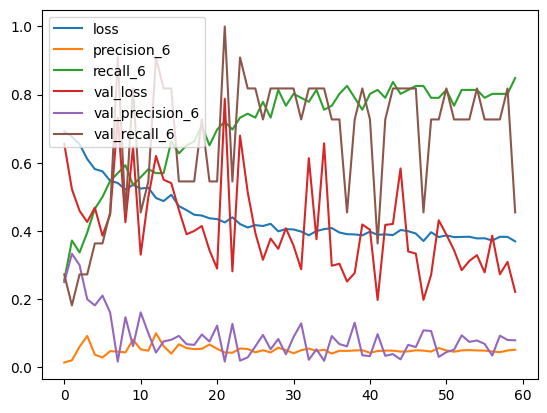

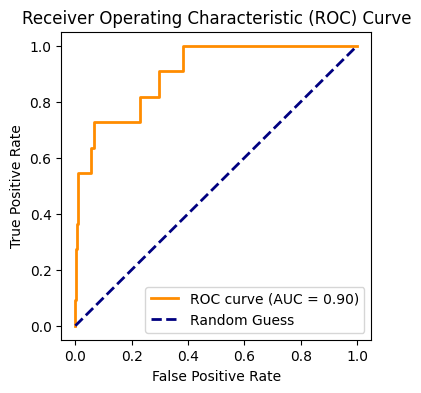

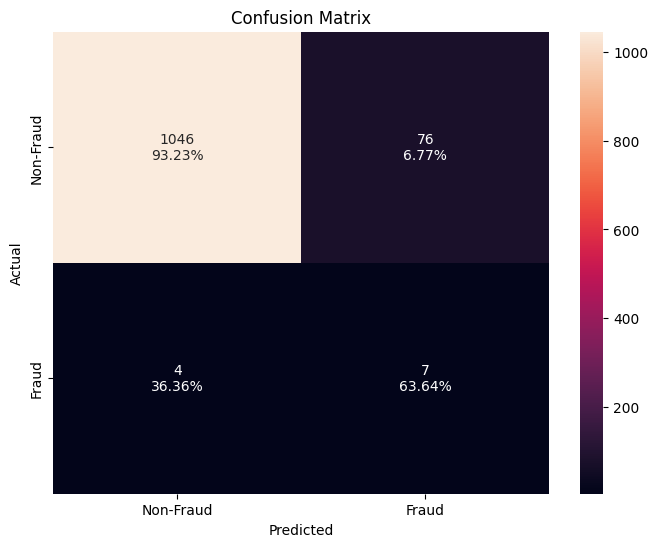

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96      1122
         1.0       0.08      0.64      0.15        11

    accuracy                           0.93      1133
   macro avg       0.54      0.78      0.56      1133
weighted avg       0.99      0.93      0.96      1133



In [20]:
# Experiment 3 - Adjust class weights
mlp_weighted_2 = keras.models.Sequential()
mlp_weighted_2.add(keras.layers.Dense(32, input_shape=(11, )))
mlp_weighted_2.add(keras.layers.Dense(16, activation='relu'))
mlp_weighted_2.add(keras.layers.Dense(8, activation='relu'))
mlp_weighted_2.add(keras.layers.Dense(1, activation='sigmoid'))
mlp_weighted_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()])

checkpoint_filepath = '/content/drive/MyDrive/final year/btc_tx_anomaly_detection/models/mlp/checkpoint_3'

#early_stopping = EarlyStopping(monitor='val_f1_score', mode='max', patience=8)

checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                             monitor='val_f1_score', mode='max', save_best_only=True)

history = mlp_weighted_2.fit(X_train, y_train, epochs=60, class_weight=class_weights, validation_data=[X_val, y_val], callbacks=[checkpoint])


mlp_weighted_2 = keras.models.load_model(checkpoint_filepath)

# show the training performance histogram
show_hist()
# make predictions on test data
predictions = make_prediction(mlp_weighted_2)
# plot the roc curve
fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=1)
plot_roc(predictions, fpr, tpr)
# take a deeper look and see how the model predicted the samples
display_cm(predictions, thresholds)

Adding class weights has had the following effect:
- Slightly reduces the recall (number of fraud transactions that are correctly identified)
- Significantly increases the precision and therefore reduces the false positive rate.

There's also some other observations:
- There is a lot of fluctuations in almost all metrics, such as loss, precision and recall. This fluctation indicates that some portion of the saples are being classified randomly as opposed to being classified as a result of some learned features.

This shows that despite adding class weights to try and make the model pay more attention to the positive samples, there still isn't sufficient information for the model to learn the underlying patterns in the data.

Possibly the best way to solve this, is to get more data. Unfortunately, in the case of fraud detection, positive samples are ofetn low, so the next best thing may be to synthetically oversample the positive (fraud) samples using oversampling techniques such as smote.

Perhaps we can try and overfit the model to perform extremely well on the validation set. Then we can try and tweak the hyperparameters to try and find a balance between optimisation and generalisation.

We can try:
- Adding drop outs
- Adding regularisation to layers
- Adding batch normalisation
- Tweaking the number or neurons, hidden layers
- Using different activation function
- Using different loss function
- Using different optimiser and learning rates

# SMOTE

In [21]:
smote = SMOTE()

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [22]:
# Count class occurrences in the resampled data
class_counts = dict(zip(*np.unique(y_train_resampled, return_counts=True)))
class_counts

{0.0: 8974, 1.0: 8974}

Epoch 1/60
561/561 [==============================] - 3s 4ms/step - loss: 0.5820 - precision_7: 0.8674 - recall_7: 0.4324 - f1_score: 0.6667 - val_loss: 0.5392 - val_precision_7: 0.1029 - val_recall_7: 0.6364 - val_f1_score: 0.0192
Epoch 2/60
561/561 [==============================] - 2s 4ms/step - loss: 0.4882 - precision_7: 0.9058 - recall_7: 0.5786 - f1_score: 0.6667 - val_loss: 0.5227 - val_precision_7: 0.0662 - val_recall_7: 0.9091 - val_f1_score: 0.0192
Epoch 3/60
561/561 [==============================] - 2s 4ms/step - loss: 0.4118 - precision_7: 0.8764 - recall_7: 0.7292 - f1_score: 0.6667 - val_loss: 0.3828 - val_precision_7: 0.0703 - val_recall_7: 0.8182 - val_f1_score: 0.0192
Epoch 4/60
561/561 [==============================] - 2s 4ms/step - loss: 0.3644 - precision_7: 0.8781 - recall_7: 0.8240 - f1_score: 0.6668 - val_loss: 0.3305 - val_precision_7: 0.0849 - val_recall_7: 0.8182 - val_f1_score: 0.0192
Epoch 5/60
561/561 [==============================] - 2s 3ms/step - loss

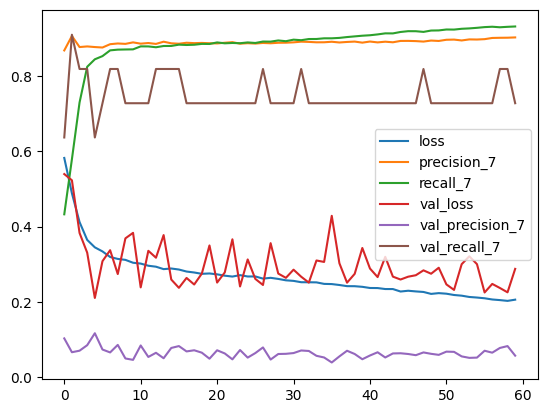

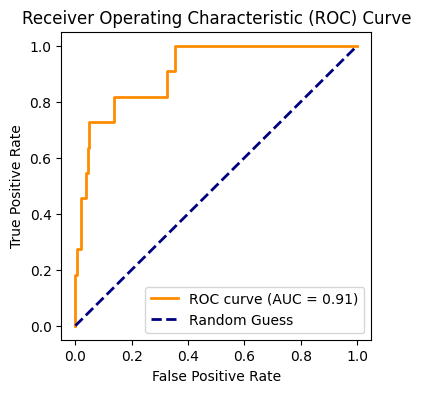

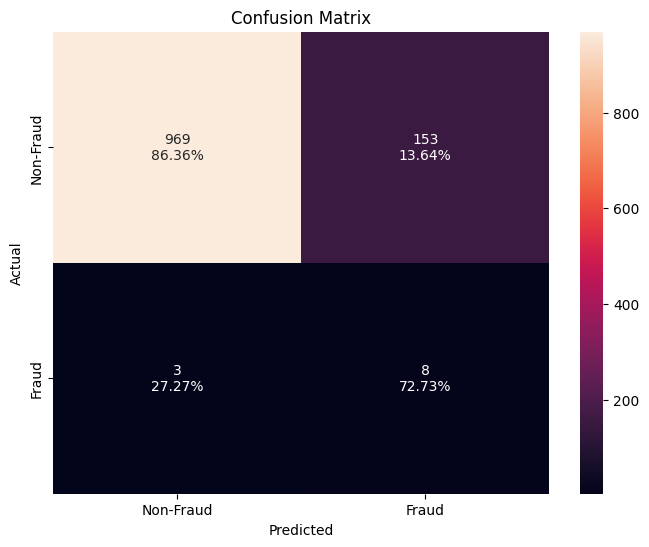

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.86      0.93      1122
         1.0       0.05      0.73      0.09        11

    accuracy                           0.86      1133
   macro avg       0.52      0.80      0.51      1133
weighted avg       0.99      0.86      0.92      1133



In [23]:
# Experiment 4 - Train with oversampled, synthetic data
mlp_smote_1 = keras.models.Sequential()
mlp_smote_1.add(keras.layers.Dense(32, input_shape=(11, )))
mlp_smote_1.add(keras.layers.Dense(16, activation='relu'))
mlp_smote_1.add(keras.layers.Dense(8, activation='relu'))
mlp_smote_1.add(keras.layers.Dense(1, activation='sigmoid'))
mlp_smote_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()])


checkpoint_filepath = '/content/drive/MyDrive/final year/btc_tx_anomaly_detection/models/mlp/checkpoint_4'

#early_stopping = EarlyStopping(monitor='val_f1_score', mode='max', patience=8)

checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                             monitor='val_f1_score', mode='max', save_best_only=True)

history = mlp_smote_1.fit(X_train_resampled, y_train_resampled, epochs=60, validation_data=[X_val, y_val], callbacks=[checkpoint])

mlp_smote_1 = keras.models.load_model(checkpoint_filepath)


# show the training performance histogram
show_hist()
# make predictions on test data
predictions = make_prediction(mlp_smote_1)
# plot the roc curve
fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=1)
plot_roc(predictions, fpr, tpr)
# take a deeper look and see how the model predicted the samples
display_cm(predictions, thresholds)

With oversampling technique we have got a slightly better model. As seen by the training plot. The metrics are fluctuating a lot less. Maybe we can try and add some regularisation to get an evern better model

Epoch 1/60
561/561 [==============================] - 7s 7ms/step - loss: 0.6393 - precision_10: 0.7170 - recall_10: 0.4159 - f1_score: 0.6667 - val_loss: 0.5304 - val_precision_10: 0.0986 - val_recall_10: 0.6364 - val_f1_score: 0.0192
Epoch 2/60
561/561 [==============================] - 1s 2ms/step - loss: 0.5341 - precision_10: 0.8415 - recall_10: 0.5995 - f1_score: 0.6667 - val_loss: 0.4040 - val_precision_10: 0.0909 - val_recall_10: 0.6364 - val_f1_score: 0.0192
Epoch 3/60
561/561 [==============================] - 1s 2ms/step - loss: 0.4807 - precision_10: 0.8560 - recall_10: 0.6924 - f1_score: 0.6667 - val_loss: 0.4552 - val_precision_10: 0.0559 - val_recall_10: 0.9091 - val_f1_score: 0.0192
Epoch 4/60
561/561 [==============================] - 2s 4ms/step - loss: 0.4221 - precision_10: 0.8461 - recall_10: 0.8013 - f1_score: 0.6668 - val_loss: 0.3039 - val_precision_10: 0.0763 - val_recall_10: 0.9091 - val_f1_score: 0.0193
Epoch 5/60
561/561 [==============================] - 2s

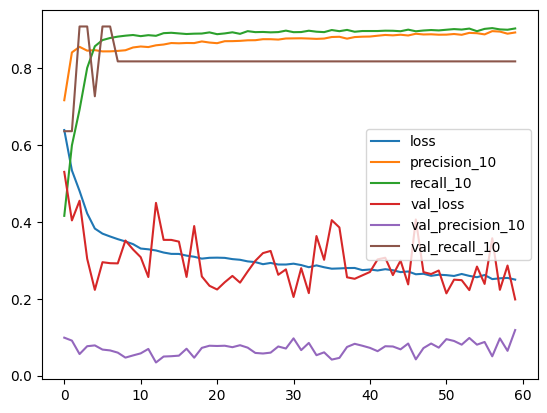

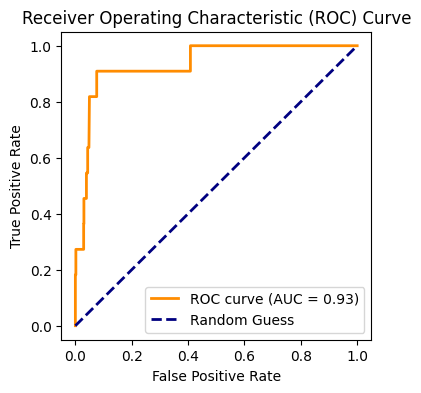

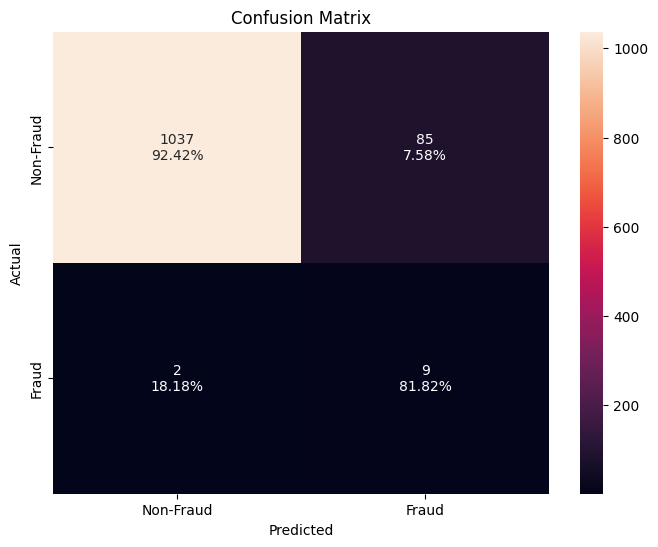

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96      1122
         1.0       0.10      0.82      0.17        11

    accuracy                           0.92      1133
   macro avg       0.55      0.87      0.57      1133
weighted avg       0.99      0.92      0.95      1133



In [26]:
# Experiment 5 - Train with oversampled, synthetic data, add two drop out layers

mlp_smote_2 = keras.models.Sequential()
mlp_smote_2.add(keras.layers.Dense(32, input_shape=(11, )))
mlp_smote_2.add(keras.layers.Dense(16, activation='relu'))
mlp_smote_2.add(keras.layers.Dropout(0.2))
mlp_smote_2.add(keras.layers.Dense(8, activation='relu'))
mlp_smote_2.add(keras.layers.Dropout(0.2))
mlp_smote_2.add(keras.layers.Dense(1, activation='sigmoid'))
mlp_smote_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()])


checkpoint_filepath = '/content/drive/MyDrive/final year/btc_tx_anomaly_detection/models/mlp/checkpoint_5'

#early_stopping = EarlyStopping(monitor='val_f1_score', mode='max', patience=8)

checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                             monitor='val_f1_score', mode='max', save_best_only=True)

history = mlp_smote_2.fit(X_train_resampled, y_train_resampled, epochs=60, validation_data=[X_val, y_val], callbacks=[checkpoint])

mlp_smote_2 = keras.models.load_model(checkpoint_filepath)


# show the training performance histogram
show_hist()
# make predictions on test data
predictions = make_prediction(mlp_smote_2)
# plot the roc curve
fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=1)
plot_roc(predictions, fpr, tpr)
# take a deeper look and see how the model predicted the samples
display_cm(predictions, thresholds)

Epoch 1/60
561/561 [==============================] - 6s 6ms/step - loss: 0.6614 - precision_11: 0.5631 - recall_11: 0.5856 - f1_score: 0.6667 - val_loss: 0.5650 - val_precision_11: 0.0632 - val_recall_11: 0.5455 - val_f1_score: 0.0192
Epoch 2/60
561/561 [==============================] - 1s 2ms/step - loss: 0.5844 - precision_11: 0.7908 - recall_11: 0.5469 - f1_score: 0.6667 - val_loss: 0.4759 - val_precision_11: 0.1200 - val_recall_11: 0.5455 - val_f1_score: 0.0192
Epoch 3/60
561/561 [==============================] - 1s 2ms/step - loss: 0.5281 - precision_11: 0.8177 - recall_11: 0.6043 - f1_score: 0.6667 - val_loss: 0.3991 - val_precision_11: 0.1071 - val_recall_11: 0.5455 - val_f1_score: 0.0192
Epoch 4/60
561/561 [==============================] - 1s 2ms/step - loss: 0.4874 - precision_11: 0.7940 - recall_11: 0.7020 - f1_score: 0.6668 - val_loss: 0.3177 - val_precision_11: 0.1000 - val_recall_11: 0.5455 - val_f1_score: 0.0192
Epoch 5/60
561/561 [==============================] - 4s

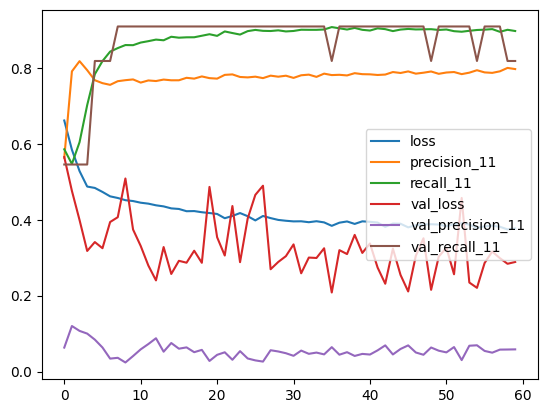

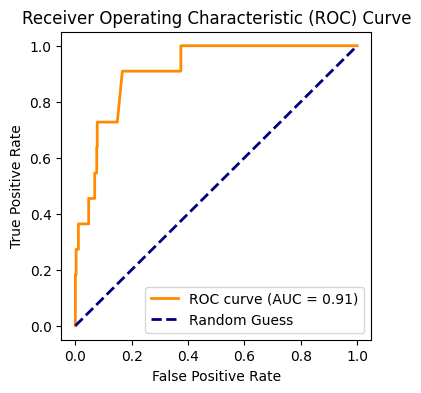

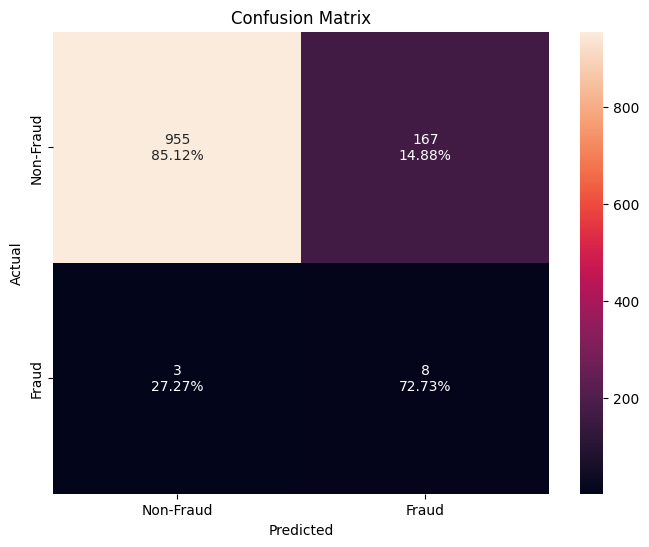

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.85      0.92      1122
         1.0       0.05      0.73      0.09        11

    accuracy                           0.85      1133
   macro avg       0.52      0.79      0.50      1133
weighted avg       0.99      0.85      0.91      1133



In [27]:
# Experiment 6 - Increase drop out rate

mlp_smote_3 = keras.models.Sequential()
mlp_smote_3.add(keras.layers.Dense(32, input_shape=(11, )))
mlp_smote_3.add(keras.layers.Dense(16, activation='relu'))
mlp_smote_3.add(keras.layers.Dropout(0.5))
mlp_smote_3.add(keras.layers.Dense(8, activation='relu'))
mlp_smote_3.add(keras.layers.Dropout(0.5))
mlp_smote_3.add(keras.layers.Dense(1, activation='sigmoid'))
mlp_smote_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()])

checkpoint_filepath = '/content/drive/MyDrive/final year/btc_tx_anomaly_detection/models/mlp/checkpoint_6'

#early_stopping = EarlyStopping(monitor='val_f1_score', mode='max', patience=8)

checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                             monitor='val_f1_score', mode='max', save_best_only=True)

history = mlp_smote_3.fit(X_train_resampled, y_train_resampled, epochs=60, validation_data=[X_val, y_val], callbacks=[checkpoint])

mlp_smote_3 = keras.models.load_model(checkpoint_filepath)

# show the training performance histogram
show_hist()
# make predictions on test data
predictions = make_prediction(mlp_smote_3)
# plot the roc curve
fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=1)
plot_roc(predictions, fpr, tpr)
# take a deeper look and see how the model predicted the samples
display_cm(predictions, thresholds)

Epoch 1/60
561/561 [==============================] - 5s 5ms/step - loss: 0.6521 - precision_12: 0.6067 - recall_12: 0.5426 - f1_score: 0.6667 - val_loss: 0.5550 - val_precision_12: 0.1250 - val_recall_12: 0.5455 - val_f1_score: 0.0192
Epoch 2/60
561/561 [==============================] - 2s 3ms/step - loss: 0.5752 - precision_12: 0.7836 - recall_12: 0.5714 - f1_score: 0.6667 - val_loss: 0.4411 - val_precision_12: 0.1224 - val_recall_12: 0.5455 - val_f1_score: 0.0192
Epoch 3/60
561/561 [==============================] - 2s 4ms/step - loss: 0.5342 - precision_12: 0.8029 - recall_12: 0.6206 - f1_score: 0.6667 - val_loss: 0.4372 - val_precision_12: 0.1000 - val_recall_12: 0.7273 - val_f1_score: 0.0192
Epoch 4/60
561/561 [==============================] - 2s 4ms/step - loss: 0.5037 - precision_12: 0.7845 - recall_12: 0.6975 - f1_score: 0.6668 - val_loss: 0.3792 - val_precision_12: 0.0849 - val_recall_12: 0.8182 - val_f1_score: 0.0192
Epoch 5/60
561/561 [==============================] - 3s

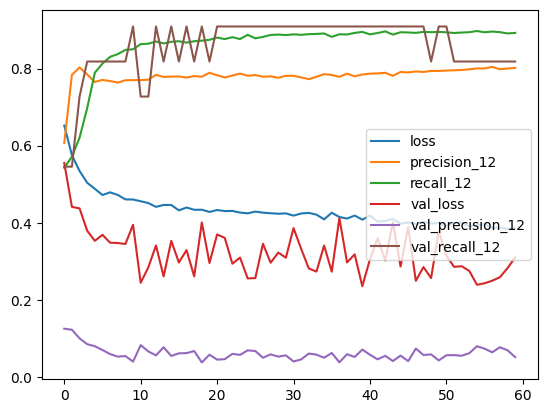

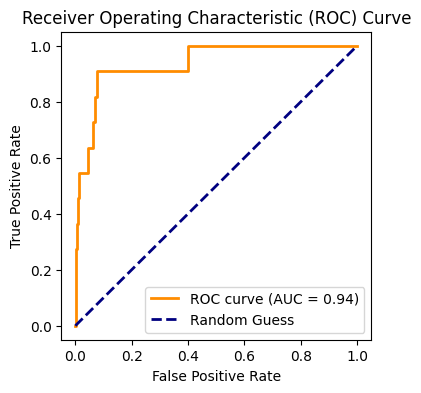

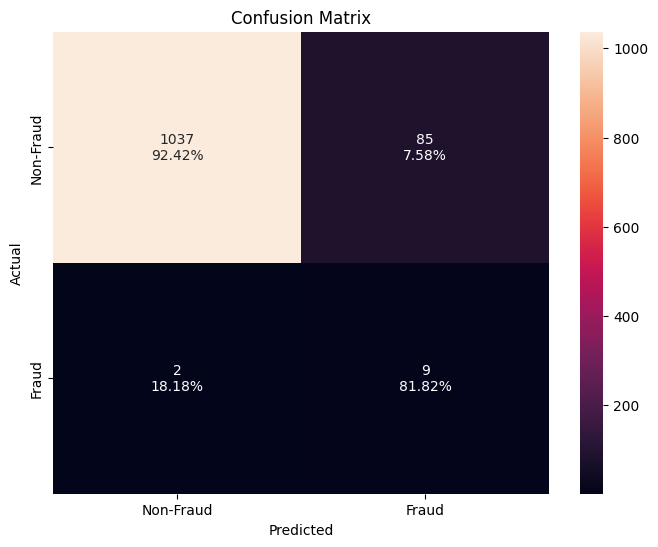

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96      1122
         1.0       0.10      0.82      0.17        11

    accuracy                           0.92      1133
   macro avg       0.55      0.87      0.57      1133
weighted avg       0.99      0.92      0.95      1133



In [28]:
# Experiment 7 - add regularisation
from keras import regularizers

mlp_smote_4 = keras.models.Sequential()
mlp_smote_4.add(keras.layers.Dense(32, input_shape=(11, )))
mlp_smote_4.add(keras.layers.Dense(16, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),activation='relu'))
mlp_smote_4.add(keras.layers.Dropout(0.5))
mlp_smote_4.add(keras.layers.Dense(8, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),activation='relu'))
mlp_smote_4.add(keras.layers.Dropout(0.5))
mlp_smote_4.add(keras.layers.Dense(1, activation='sigmoid'))
mlp_smote_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()])

checkpoint_filepath = '/content/drive/MyDrive/final year/btc_tx_anomaly_detection/models/mlp/checkpoint_6'

#early_stopping = EarlyStopping(monitor='val_f1_score', mode='max', patience=8)

checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                             monitor='val_f1_score', mode='max', save_best_only=True)

history = mlp_smote_4.fit(X_train_resampled, y_train_resampled, epochs=60, validation_data=[X_val, y_val], callbacks=[checkpoint])

mlp_smote_4 = keras.models.load_model(checkpoint_filepath)

# show the training performance histogram
show_hist()
# make predictions on test data
predictions = make_prediction(mlp_smote_4)
# plot the roc curve
fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=1)
plot_roc(predictions, fpr, tpr)
# take a deeper look and see how the model predicted the samples
display_cm(predictions, thresholds)

Now that we have some synthetic data, perhaps we can try increase the network size to try and see of our model can learn from the duplciated data points

Epoch 1/60
561/561 [==============================] - 7s 9ms/step - loss: 0.6937 - precision_14: 0.5225 - recall_14: 0.3321 - f1_score: 0.6667 - val_loss: 0.6796 - val_precision_14: 0.1818 - val_recall_14: 0.3636 - val_f1_score: 0.0192
Epoch 2/60
561/561 [==============================] - 2s 4ms/step - loss: 0.6474 - precision_14: 0.7804 - recall_14: 0.3599 - f1_score: 0.6667 - val_loss: 0.6098 - val_precision_14: 0.1250 - val_recall_14: 0.5455 - val_f1_score: 0.0192
Epoch 3/60
561/561 [==============================] - 2s 3ms/step - loss: 0.6238 - precision_14: 0.8522 - recall_14: 0.3925 - f1_score: 0.6667 - val_loss: 0.5580 - val_precision_14: 0.1667 - val_recall_14: 0.4545 - val_f1_score: 0.0192
Epoch 4/60
561/561 [==============================] - 2s 3ms/step - loss: 0.6170 - precision_14: 0.8553 - recall_14: 0.4049 - f1_score: 0.6667 - val_loss: 0.5497 - val_precision_14: 0.1515 - val_recall_14: 0.4545 - val_f1_score: 0.0192
Epoch 5/60
561/561 [==============================] - 2s

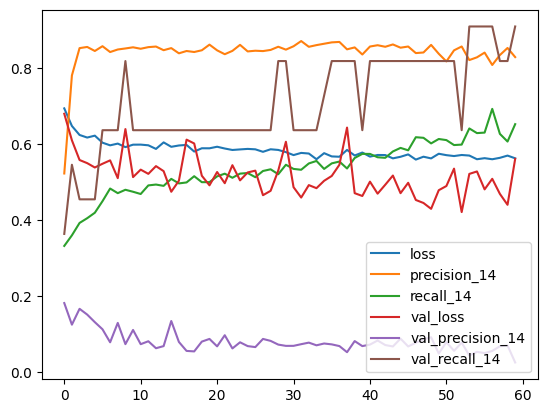

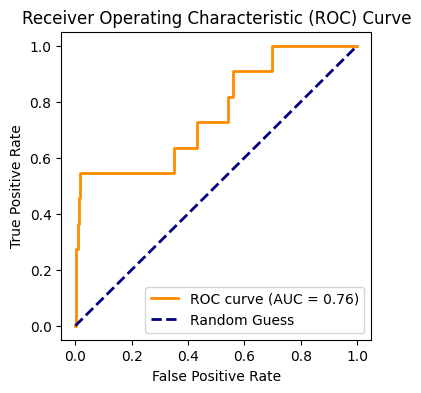

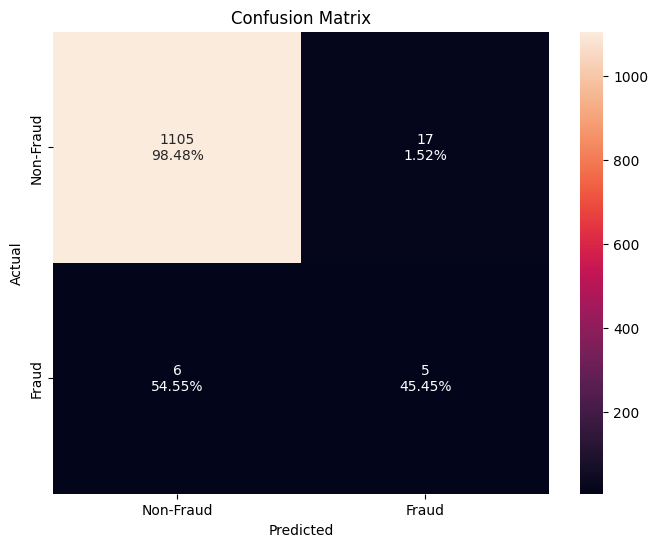

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      1122
         1.0       0.23      0.45      0.30        11

    accuracy                           0.98      1133
   macro avg       0.61      0.72      0.65      1133
weighted avg       0.99      0.98      0.98      1133



In [30]:
# Experiment 8 - increase network size

mlp_smote_5 = keras.models.Sequential()
mlp_smote_5.add(keras.layers.Dense(32, input_shape=(11, )))
mlp_smote_5.add(keras.layers.Dense(16, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),activation='relu'))
mlp_smote_5.add(keras.layers.Dropout(0.5))
mlp_smote_5.add(keras.layers.Dense(12, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),activation='relu'))
mlp_smote_5.add(keras.layers.Dropout(0.5))
mlp_smote_5.add(keras.layers.Dense(8, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),activation='relu'))
mlp_smote_5.add(keras.layers.Dropout(0.5))
mlp_smote_5.add(keras.layers.Dense(4, kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),activation='relu'))
mlp_smote_5.add(keras.layers.Dropout(0.5))
mlp_smote_5.add(keras.layers.Dense(1, activation='sigmoid'))
mlp_smote_5.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()])

checkpoint_filepath = '/content/drive/MyDrive/final year/btc_tx_anomaly_detection/models/mlp/checkpoint_7'

#early_stopping = EarlyStopping(monitor='val_f1_score', mode='max', patience=8)

checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                             monitor='val_f1_score', mode='max', save_best_only=True)

history = mlp_smote_5.fit(X_train_resampled, y_train_resampled, epochs=60, validation_data=[X_val, y_val], callbacks=[checkpoint])

mlp_smote_5 = keras.models.load_model(checkpoint_filepath)

# show the training performance histogram
show_hist()
# make predictions on test data
predictions = make_prediction(mlp_smote_5)
# plot the roc curve
fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=1)
plot_roc(predictions, fpr, tpr)
# take a deeper look and see how the model predicted the samples
display_cm(predictions, thresholds)

This performs slightly better. the model has a lower false negative rate which is good but the true positive rate is only 72%, which is not acceptable in a fraud detection scenario. Having a slightly higher false negative rate is acceptable so long as the the recall for catching fraud transactions is as close to 100% as possible because the cost of failure to detect a fraud transaction is far higher then the cost of mislabelling a legit transaction as fraudulent.

I will tweak whatever parameters in this next experiment to try and atleast get the recall for positive classes be as close to 100% as possible, but I will not record down all the iterations, I will only record the results of the best combination I can find.

## Hyperparameter Tuning using keras tuner

In [31]:
def model_builder(hp):
  model = keras.models.Sequential()

  # Define the hyperparameters
  input_shape = (11, )
  hp_activation = hp.Choice('activation', values=['relu', 'tanh'])
  hp_input_neurons = hp.Int('input_layer', min_value=1, max_value=200, step=10)
  hp_dense_layers = hp.Int('dense_layer', min_value=0, max_value=8, step=1)
  hp_dense_neurons = hp.Int('dense_neurons', min_value=1, max_value=200, step=10)
  hp_optimizer = hp.Choice('optimiser', values=['SGD', 'Adam'])
  hp_learning_rate = hp.Choice('learning_rate', values=[0.001, 0.005, 0.01, 0.05, 0.1])
  hp_dropout_prob = hp.Float('dropout_prob', min_value=0.0, max_value=1.0, step=0.1, default=0.0)
  hp_dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)

  # Create the input layer
  model.add(keras.layers.Dense(hp_input_neurons, input_shape=input_shape))

  # create the dense layers
  for i in range(hp_dense_layers):
    neurons = (int)(hp_dense_neurons / (i+1))
    model.add(keras.layers.Dense(neurons, activation=hp_activation))
    # Add drop out layer
    if hp_dropout_prob > 0.5:
      model.add(keras.layers.Dropout(hp_dropout_rate))


  # Create the output layer
  model.add(keras.layers.Dense(1, activation='sigmoid'))

  # Create optimiser
  if hp_optimizer == 'SGD':
        optimizer = keras.optimizers.SGD(learning_rate=hp_learning_rate)
  else:
        optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)

  # Compile the model
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()])

  return model

In [32]:
tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective("val_f1_score", direction="max"),
                     max_epochs=10,
                     factor=3,
                     directory='/content/drive/MyDrive/final year/btc_tx_anomaly_detection/Experiments/MLP/',
                     project_name='MLP_model_f1_smote')

Reloading Tuner from /content/drive/MyDrive/final year/btc_tx_anomaly_detection/Experiments/MLP/MLP_model_f1_smote/tuner0.json


In [28]:
early_stopping = EarlyStopping(monitor='val_f1_score', patience=10)

In [29]:
tuner.search(X_train_resampled, y_train_resampled, epochs=30, validation_data=[X_val, y_val], callbacks=[early_stopping])

Trial 30 Complete [00h 00m 48s]
val_f1_score: 0.019247593358159065

Best val_f1_score So Far: 0.019247593358159065
Total elapsed time: 00h 09m 47s


In [33]:
best_hps = tuner.get_best_hyperparameters()[0]
best_hps.values

{'activation': 'tanh',
 'input_layer': 121,
 'dense_layer': 3,
 'dense_neurons': 181,
 'optimiser': 'Adam',
 'learning_rate': 0.001,
 'dropout_prob': 0.1,
 'dropout_rate': 0.30000000000000004,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 2,
 'tuner/round': 0}

### Get the best models

In [34]:
tuned_mlp_smote = tuner.get_best_models()[0]

36/36 [==============================] - 0s 2ms/step


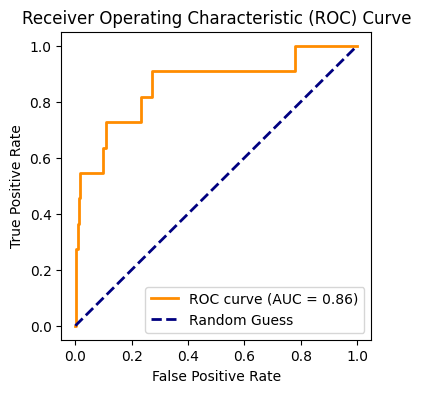

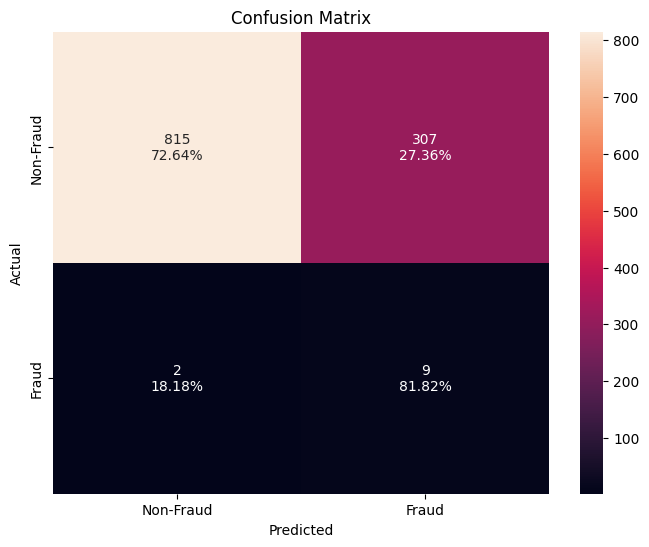

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.73      0.84      1122
         1.0       0.03      0.82      0.06        11

    accuracy                           0.73      1133
   macro avg       0.51      0.77      0.45      1133
weighted avg       0.99      0.73      0.83      1133



In [35]:
# make predictions on test data
predictions = make_prediction(tuned_mlp_smote)
# plot the roc curve
fpr, tpr, thresholds = roc_curve(y_test, predictions, pos_label=1)
plot_roc(predictions, fpr, tpr)
# take a deeper look and see how the model predicted the samples
display_cm(predictions, thresholds)

## Experimental Results:


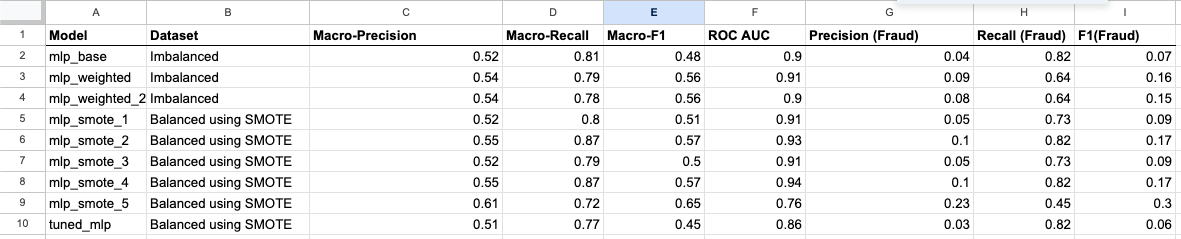

In [39]:
from IPython.display import Image, display
display(Image(filename='/content/drive/MyDrive/final year/btc_tx_anomaly_detection/Experiments/MLP/results.png'))
